In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.preprocessing.image as image


In [2]:
np.set_printoptions(threshold=np.inf)#控制台输出所有的值，不需要省略号
#预处理
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#数据集切分
x_valid,x_train=x_train[:3000],x_train[3000:]
y_valid,y_train=y_train[:3000],y_train[3000:]

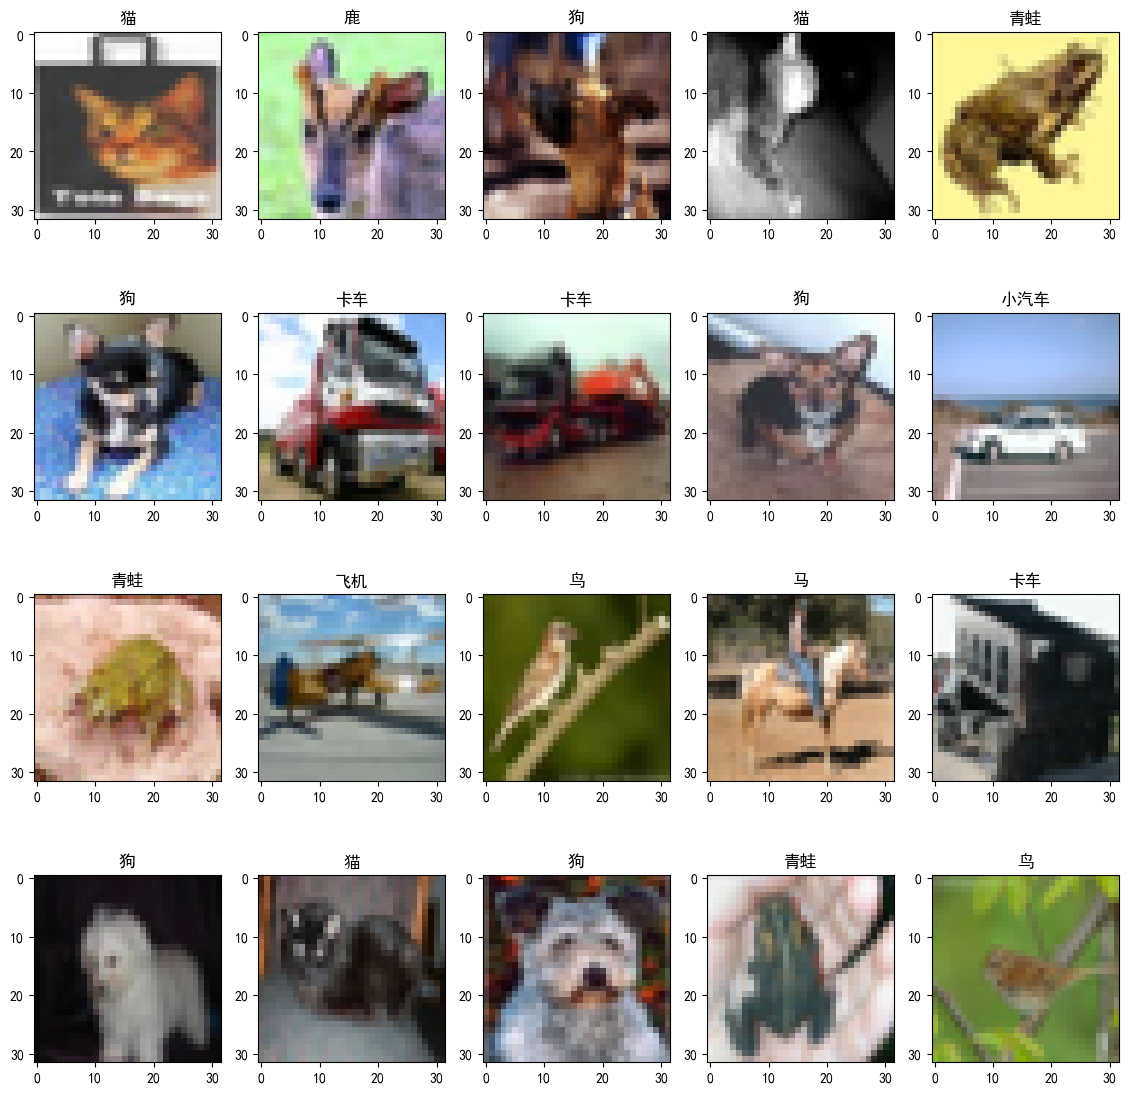

In [3]:
#数据展示
labels = ['飞机','小汽车','鸟','猫','鹿','狗','青蛙','马','船','卡车']
plt.figure(figsize=(14,14)) 
#显示前10张图像，并在图像上显示类别
for i in range(20):   
    plt.subplot(4,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i,:,:,],cmap=plt.cm.binary)
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    t = labels[y_train[i][0]]
    plt.title(t) 
plt.show()

In [4]:
class SparseConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, p, **kwargs):
        super(SparseConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.p = tf.Variable(float(p), trainable=False)  # 将 p 转换为浮点数类型
        self.counter = tf.Variable(0, trainable=False, dtype=tf.int32)  # 初始化计数器

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.filters,),
                                    initializer='zeros',
                                    trainable=True)

    @tf.function
    def call(self, inputs, training=None):
        if training:
            mask = tf.random.uniform(shape=(self.filters,), minval=0, maxval=1)
            mask = tf.cast(mask < self.p, dtype=tf.float32)
            mask = tf.reshape(mask, [1, 1, 1, self.filters])
            #tf.print("Training: Mask applied with sparsity", self.p)
        else:
            mask = tf.ones([1, 1, 1, self.filters], dtype=tf.float32) * self.p
            #tf.print("Inference: Mask applied with sparsity", self.p)
    
        sparse_kernel = self.kernel * mask
        conv = tf.nn.conv2d(inputs, sparse_kernel, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.bias_add(conv, self.bias)

    @tf.function
    def update_p(self, new_p):
        self.p.assign(float(new_p))  # 使用 assign 更新 tf.Variable 的值，并转换为浮点数
        #tf.print("Updated sparsity to", self.p)


In [5]:
class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False, use_sparse_conv=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path
        self.use_sparse_conv = use_sparse_conv

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same',
                         kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        if self.use_sparse_conv:
            self.c2 = SparseConv2D(filters=filters, kernel_size=3, p=1, name='sparse_conv2d_3')
            self.b2 = BatchNormalization()
        else:
            self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', 
                             kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
            self.b2 = BatchNormalization()

        
        if residual_path or strides != 1:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', 
                                  kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
            self.down_b1 = BatchNormalization()
        else:
            self.down_c1 = None
        
        self.a2 = Activation('relu')

    def call(self, inputs, training=None):
        residual = inputs
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        #if self.use_sparse_conv:
            #tf.print("Using SparseConv2D in ResnetBlock")
        #else:
            #tf.print("Using standard Conv2D in ResnetBlock")
            
        x = self.c2(x, training=training)
        x = self.b2(x)

        if self.down_c1 is not None:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(x + residual)
        return out


In [6]:
class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list表示每个block有几个卷积层
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)  # 共有几个block
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.blocks = tf.keras.models.Sequential()
        self.sparse_conv = None  # 用于保存SparseConv2D层的引用
        # 构建ResNet网络结构
        for block_id in range(len(block_list)):  # 第几个resnet block
            for layer_id in range(block_list[block_id]):  # 第几个卷积层
                use_sparse_conv = False
                # 在最后一个block的最后一个卷积层中使用自定义卷积层
                if block_id == len(block_list) - 1 and layer_id == block_list[block_id] - 1:
                    use_sparse_conv = True

                if block_id != 0 and layer_id == 0:  # 对除第一个block以外的每个block的输入进行下采样
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True, use_sparse_conv=use_sparse_conv)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False, use_sparse_conv=use_sparse_conv)
                
                if use_sparse_conv:
                    self.sparse_conv = block.c2  # 保存对SparseConv2D层的引用

                self.blocks.add(block)  # 将构建好的block加入resnet
            self.out_filters *= 2  # 下一个block的卷积核数是上一个block的2倍
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())  # 加softmax

    def call(self, inputs, training=None):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x, training=training)
        x = self.p1(x)
        y = self.f1(x)
        return y


In [7]:
class UpdatePSparsity(tf.keras.callbacks.Callback):
    def __init__(self, model, sparsity_schedule):
        super(UpdatePSparsity, self).__init__()
        self.model = model
        self.sparsity_schedule = sparsity_schedule

    def on_epoch_end(self, epoch, logs=None):
        if self.model.sparse_conv is not None:
            layer = self.model.sparse_conv
            if epoch < len(self.sparsity_schedule):
                p_value = self.sparsity_schedule[epoch]
            else:
                p_value = self.sparsity_schedule[-1]  # Use the last value for epochs beyond the predefined ones
            layer.update_p(p_value)


In [8]:
#模型训练
def model_train(x_train,y_train,x_valid,y_valid):
    
    model = ResNet18([2, 2, 2, 2])
    save_path = 'resnet18.h5'

    # 使用较小的学习率和 Adam 优化器
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])

        
    # 确保模型构建
    model.build(input_shape=(None, 32, 32, 3))
    model.summary()
    
    checkpoint_save_path = "ResNet18.ckpt"
    if os.path.exists(checkpoint_save_path + '.index'):
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./model',histogram_freq =1,write_grads=True)
    sparsity_schedule = [1]  # 假设 sparsity_schedule 是一个列表
    history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), validation_freq=1,
                        callbacks=[tensorboard, UpdatePSparsity(model, sparsity_schedule)])
    #history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid), validation_freq=1,
                #   callbacks=[cp_callback])
    
    #权值保存
    file = open('./weights.txt', 'w')
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')
    file.close()
   
    #模型保存
    #model_path ='resnet18.h5'
    #tf.saved_model.save(model,model_path)
    #模型图保存
    plot_model(model, to_file='resnet18_model.jpg',show_shapes=True)
    return history,model

In [9]:
#数据可视化
def figshow(history):
    '''
    introductoin:  数据可视化，画出训练损失函数和验证集上的准确率
    '''
    # 显示训练集和验证集的acc和loss曲线
    print('\n\n\n')
    print('----------------------------------------------图像绘制-------------------------------------')
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplots(figsize=(8,6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.subplots(figsize=(8,6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [10]:
#测试集测试
def data_test(x_test,y_test,model):
    '''
    @introduction :输出模型在测试集上的top1准确率和top2准确率
    @parameter ：
               x_test  测试集数据
               y_test  测试数据标签
               model   训练好的模型
    @return :
              top1_acc   top1标准下的准确率
              top2_acc   top2标准下的准确率
    
    '''
    print('****************************test******************************')
    loss, acc = model.evaluate(x_test, y_test)
    top1_acc = acc
    
    #print("test_accuracy:{:5.2f}%".format(100 * acc))
    y_pred = model.predict(x_test)
    k_b = tf.math.top_k(y_pred,2).indices
    idx=0
    acc=0.0
    for i in k_b:
        if y_test[idx] in i.numpy():
            acc=acc+1
        idx=idx+1
    top2_acc=acc/y_test.shape[0] 
    print('\n测试输出')
    print('top1准确率：{0}\ntop2准确率：{1}'.format(top1_acc,top2_acc))
    return top1_acc,top2_acc

In [ ]:
if __name__ == '__main__':
    #训练
    history,model=model_train(x_train,y_train,x_test,y_test)
    figshow(history)
    
    #测试
    data_test(x_test,y_test,model)

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1728      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 sequential (Sequential)     (None, 4, 4, 512)         11176962  
                                                                 
 sparse_conv2d_3 (SparseConv  multiple                 2359810   
 2D)                                                             
                                                                 
 global_average_pooling2d (G  multiple                 0 